# Use a label sample to calibrate the estimation on a base dataset

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from util import plot_stacked_frequency
from util import DataHandler, NPBinningCalibrationCurve, LogisticCalibrationCurve, ProbabilityEstimator

## 1. Load an unlabeled dataset

In [2]:
# base is a very large dataset
base_dh = DataHandler('data/dataset1_base.csv')

In [3]:
# TODO: change the dataset to 'data/dataset1_target.csv'
# base_dh = DataHandler('data/dataset1_target.csv')

In [4]:
# you observe only classifier scores C(X), but no GT labels
base_dh.observed_df

,C(X),GT
0,0.254796,
1,0.888630,
2,0.815468,
3,0.801820,
4,0.209585,
...,...,...
99995,0.383462,
99996,0.937050,
99997,0.066808,
99998,0.358555,


In [5]:
# count_gt() function returns the number of items with GT labels
base_dh.count_gt()

0

## 2. Assume that we have some budget to obtain the GT labels

In [6]:
# the `get_oracle_labels` function will get the GT labels for specifc rows
base_dh.get_oracle_labels(rows=[0, 1, 2])

In [7]:
base_dh.observed_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,
4,0.209585,
...,...,...
99995,0.383462,
99996,0.937050,
99997,0.066808,
99998,0.358555,


In [8]:
# we can also get a subset of all labeled rows
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True


### 2.1 Random sampling

In [9]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='random')

In [10]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [11]:
base_dh.count_gt()

5003

In [12]:
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
13,0.448847,False
15,0.182088,False
...,...,...
99966,0.197190,False
99970,0.371773,False
99985,0.384530,False
99993,0.566899,False


In [13]:
random_sample_df = base_dh.sample_df

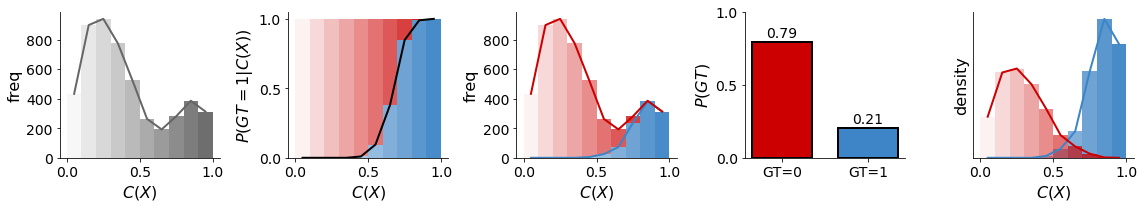

In [14]:
base_dh.generate_all_distribution_plots(df=random_sample_df, num_bin=10)

In [15]:
# def estimator(dh, labeled_df):
    # get a calibration curve for this labeled df and distribution of C(X) of the observed 1M df
    # run our intergral to get an estimation

### Estimating with PE, but just once

#### Using NPBinningCalibrationCurve

In [35]:
pe_estimator = ProbabilityEstimator()

sample_calibration_curve = NPBinningCalibrationCurve(random_sample_df, num_bin=50)
pe_estimator.set_calibration_curve(sample_calibration_curve)

input_cx_array = base_dh.observed_df['C(X)'].values

pe_estimator.estimate(input_cx_array)

0.20003220089634433

#### Using LogisticCalibrationCurve

In [36]:
pe_estimator = ProbabilityEstimator()

sample_calibration_curve = LogisticCalibrationCurve()
sample_calibration_curve.fit(random_sample_df)
pe_estimator.set_calibration_curve(sample_calibration_curve)

input_cx_array = base_dh.observed_df['C(X)'].values

pe_estimator.estimate(input_cx_array)

0.200565019669186

### Obtaining confidence interval by Bootstrap sampling

In [37]:
def bootstrap_estimating(df, num_bootstrap, calibration_curve='platt scaling', verbose=False):
    # sample with replacement on the 5000 labeled df

    pe_estimator = ProbabilityEstimator()
    input_cx_array = base_dh.observed_df['C(X)'].values

    estimated_result_list = []

    for bootstrap_idx in range(num_bootstrap):
        n_item = len(df)
        bootstrapped_sample_df = df.sample(frac=1, replace=True)

        if calibration_curve == 'platt scaling':
            bootstrapped_calibration_curve = LogisticCalibrationCurve()
            bootstrapped_calibration_curve.fit(bootstrapped_sample_df)
        elif calibration_curve == 'nonparametric binning':
            bootstrapped_calibration_curve = NPBinningCalibrationCurve(bootstrapped_sample_df, num_bin=10)

        pe_estimator.set_calibration_curve(bootstrapped_calibration_curve)

        bootstrapped_pe_estimation = pe_estimator.estimate(input_cx_array)
        if verbose:
            print(f'{bootstrap_idx:>3}: {bootstrapped_pe_estimation:.4f}')
        estimated_result_list.append(bootstrapped_pe_estimation)    
    return estimated_result_list

In [38]:
npbin_estimated_result_list = bootstrap_estimating(random_sample_df, num_bootstrap=100, calibration_curve='nonparametric binning', verbose=True)

  0: 0.1993
  1: 0.1987
  2: 0.1979
  3: 0.2004
  4: 0.1972
  5: 0.1971
  6: 0.1984
  7: 0.1961
  8: 0.2004
  9: 0.2015
 10: 0.2005
 11: 0.1993
 12: 0.1991
 13: 0.2016
 14: 0.1974
 15: 0.2017
 16: 0.2027
 17: 0.1981
 18: 0.2003
 19: 0.1992
 20: 0.2002
 21: 0.1996
 22: 0.1963
 23: 0.1956
 24: 0.2002
 25: 0.2009
 26: 0.1984
 27: 0.2008
 28: 0.2033
 29: 0.1974
 30: 0.2001
 31: 0.2001
 32: 0.2044
 33: 0.2002
 34: 0.1982
 35: 0.1980
 36: 0.2010
 37: 0.2017
 38: 0.1978
 39: 0.1966
 40: 0.1996
 41: 0.1995
 42: 0.1982
 43: 0.1992
 44: 0.1999
 45: 0.1967
 46: 0.2008
 47: 0.1971
 48: 0.1993
 49: 0.2042
 50: 0.1990
 51: 0.2021
 52: 0.1995
 53: 0.1979
 54: 0.1977
 55: 0.2022
 56: 0.1980
 57: 0.1980
 58: 0.2013
 59: 0.1967
 60: 0.2019
 61: 0.2002
 62: 0.2029
 63: 0.2007
 64: 0.1976
 65: 0.2014
 66: 0.2012
 67: 0.2019
 68: 0.1964
 69: 0.2004
 70: 0.1980
 71: 0.1969
 72: 0.1984
 73: 0.1935
 74: 0.2003
 75: 0.1999
 76: 0.1991
 77: 0.1964
 78: 0.2016
 79: 0.2000
 80: 0.2030
 81: 0.2040
 82: 0.1983
 83:

In [39]:
def get_median_CI(estimated_result_list):
    return np.median(estimated_result_list), np.percentile(estimated_result_list, 2.5), np.percentile(estimated_result_list, 97.5)

In [40]:
get_median_CI(npbin_estimated_result_list)

(0.19960969565292103, 0.1962045328209937, 0.2036795390781846)

In [41]:
ps_estimated_result_list = bootstrap_estimating(random_sample_df, num_bootstrap=100, calibration_curve='platt scaling', verbose=True)

  0: 0.2013
  1: 0.2020
  2: 0.2011
  3: 0.1998
  4: 0.2028
  5: 0.1995
  6: 0.2052
  7: 0.1992
  8: 0.2039
  9: 0.1978
 10: 0.1977
 11: 0.1990
 12: 0.2015
 13: 0.1966
 14: 0.1995
 15: 0.2021
 16: 0.1989
 17: 0.2010
 18: 0.2024
 19: 0.2004
 20: 0.1984
 21: 0.2001
 22: 0.2013
 23: 0.2019
 24: 0.1986
 25: 0.2031
 26: 0.1957
 27: 0.2010
 28: 0.1988
 29: 0.1995
 30: 0.2030
 31: 0.2016
 32: 0.2015
 33: 0.1997
 34: 0.1982
 35: 0.2012
 36: 0.2013
 37: 0.1981
 38: 0.1976
 39: 0.2000
 40: 0.2012
 41: 0.2001
 42: 0.2015
 43: 0.2014
 44: 0.2011
 45: 0.2035
 46: 0.1988
 47: 0.1994
 48: 0.1995
 49: 0.2021
 50: 0.2011
 51: 0.1958
 52: 0.2049
 53: 0.2019
 54: 0.2010
 55: 0.1990
 56: 0.2006
 57: 0.1977
 58: 0.1994
 59: 0.2013
 60: 0.1980
 61: 0.2008
 62: 0.1980
 63: 0.2011
 64: 0.2023
 65: 0.2042
 66: 0.1983
 67: 0.2012
 68: 0.2018
 69: 0.2021
 70: 0.2002
 71: 0.2008
 72: 0.2002
 73: 0.2019
 74: 0.2015
 75: 0.1977
 76: 0.2006
 77: 0.1973
 78: 0.2012
 79: 0.2004
 80: 0.1995
 81: 0.2051
 82: 0.2031
 83:

In [42]:
get_median_CI(ps_estimated_result_list)

(0.2008001817092056, 0.1966974750058021, 0.20458216656448291)

## Why 

### 2.2 Uniform sampling on C(X)

check if uniform will give us a tighter confidence intervals

In [43]:
base_dh.hide_all_oracle()

In [44]:
base_dh.count_gt()

0

In [45]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=1000, strategy='uniform on C(X)')

In [46]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [47]:
base_dh.count_gt()

1000

In [48]:
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,True
4,0.209585,False
...,...,...
2442,0.654026,True
2445,0.669955,False
2521,0.676332,True
2547,0.645266,True


In [49]:
purposive_sample_df = base_dh.sample_df

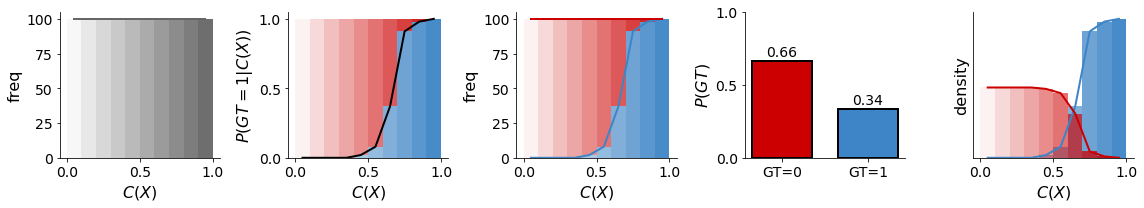

In [50]:
base_dh.generate_all_distribution_plots(df=purposive_sample_df, num_bin=10)

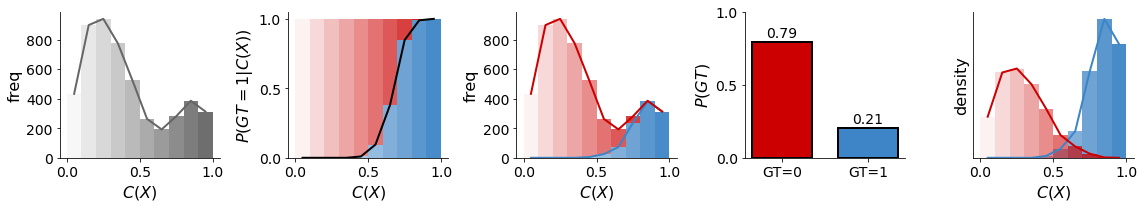

In [51]:
base_dh.generate_all_distribution_plots(df=random_sample_df, num_bin=10)

### What if we use a different sample df?

In [53]:
npbin_estimated_result_list = bootstrap_estimating(purposive_sample_df, num_bootstrap=100, calibration_curve='nonparametric binning', verbose=True)

  0: 0.2039
  1: 0.2027
  2: 0.2053
  3: 0.1981
  4: 0.2031
  5: 0.2060
  6: 0.2010
  7: 0.2027
  8: 0.2044
  9: 0.2007
 10: 0.1988
 11: 0.1957
 12: 0.2031
 13: 0.2027
 14: 0.2034
 15: 0.2059
 16: 0.2041
 17: 0.2011
 18: 0.2014
 19: 0.1999
 20: 0.2010
 21: 0.2051
 22: 0.2044
 23: 0.1978
 24: 0.2046
 25: 0.2046
 26: 0.2027
 27: 0.2025
 28: 0.1956
 29: 0.2010
 30: 0.2004
 31: 0.2017
 32: 0.2083
 33: 0.1981
 34: 0.1939
 35: 0.2059
 36: 0.2028
 37: 0.1945
 38: 0.2013
 39: 0.1992
 40: 0.2096
 41: 0.2034
 42: 0.1997
 43: 0.2000
 44: 0.2039
 45: 0.2076
 46: 0.1992
 47: 0.2017
 48: 0.2051
 49: 0.2022
 50: 0.1996
 51: 0.1993
 52: 0.1990
 53: 0.2042
 54: 0.2042
 55: 0.1988
 56: 0.2010
 57: 0.1972
 58: 0.2019
 59: 0.1999
 60: 0.1991
 61: 0.2068
 62: 0.2019
 63: 0.2027
 64: 0.1998
 65: 0.2014
 66: 0.2044
 67: 0.2035
 68: 0.2045
 69: 0.2002
 70: 0.2057
 71: 0.1998
 72: 0.1990
 73: 0.2021
 74: 0.2070
 75: 0.1997
 76: 0.2014
 77: 0.2001
 78: 0.1995
 79: 0.2082
 80: 0.2012
 81: 0.1994
 82: 0.2010
 83:

In [54]:
get_median_CI(npbin_estimated_result_list)

(0.2014390307200452, 0.19565537431071953, 0.2079171629171394)

In [55]:
ps_estimated_result_list = bootstrap_estimating(purposive_sample_df, num_bootstrap=100, calibration_curve='platt scaling', verbose=True)

  0: 0.2078
  1: 0.2068
  2: 0.2107
  3: 0.2057
  4: 0.2032
  5: 0.2046
  6: 0.2097
  7: 0.2105
  8: 0.2124
  9: 0.2114
 10: 0.2129
 11: 0.2127
 12: 0.2060
 13: 0.2117
 14: 0.2128
 15: 0.2107
 16: 0.2142
 17: 0.2113
 18: 0.2149
 19: 0.2061
 20: 0.2048
 21: 0.2036
 22: 0.2006
 23: 0.2058
 24: 0.2056
 25: 0.2076
 26: 0.2061
 27: 0.2027
 28: 0.2013
 29: 0.2093
 30: 0.2066
 31: 0.2093
 32: 0.2116
 33: 0.2102
 34: 0.2022
 35: 0.2079
 36: 0.2038
 37: 0.2076
 38: 0.2100
 39: 0.2024
 40: 0.2029
 41: 0.2092
 42: 0.2134
 43: 0.2055
 44: 0.2071
 45: 0.1949
 46: 0.2141
 47: 0.2124
 48: 0.2087
 49: 0.2046
 50: 0.2063
 51: 0.2094
 52: 0.2097
 53: 0.2124
 54: 0.2090
 55: 0.2124
 56: 0.2117
 57: 0.2103
 58: 0.1995
 59: 0.2019
 60: 0.2128
 61: 0.2116
 62: 0.2050
 63: 0.2117
 64: 0.2075
 65: 0.2066
 66: 0.2106
 67: 0.2095
 68: 0.2109
 69: 0.2061
 70: 0.2146
 71: 0.2044
 72: 0.2068
 73: 0.2124
 74: 0.2094
 75: 0.2067
 76: 0.2065
 77: 0.2046
 78: 0.2047
 79: 0.2150
 80: 0.2139
 81: 0.2106
 82: 0.1960
 83:

In [56]:
get_median_CI(ps_estimated_result_list)

(0.20784127930226917, 0.19895216098477497, 0.21477595603066207)

## Sec 3. Extrapolation phase

show the five distribution plots for the base period in one row

### 3.1 Borrow the calibration curve learned from the base dataset

In [ ]:
PE_Estimator(target_dh, calibration_curve_base)

In [ ]:
# fill in the result spreadsheet

### 3.3 Borrow the class-conditional densities learned from the base dataset

Introduce the MM model

In [ ]:
MM_Estimator(target_dh, class_density_base)

In [ ]:
# bootstrap

In [ ]:
base_dh.plot_calibration_curve(df=base_dh.sample_df, num_bin=100, method='platt scaling', title='sample_calibration_curve')

In [ ]:
labeled_sample = base_dh.get_labeled_sample()
items = [(cx, gt) for cx, gt in zip(labeled_sample['UC(X)'].values, labeled_sample['GT'].values)]
num_sample = len(items)

In [ ]:
# bootstrap for CI
num_bootstrap = 1000
results = np.zeros((num_bootstrap, 101))
est_result_list = []
target_results = np.zeros((num_bootstrap, 101))
target_result_list = []

In [ ]:
empir_cx_axis = np.linspace(0, 1, 101)
for idx in range(num_bootstrap):
    bootstrapped_items = random.choices(items, k=num_sample)
    bootstrapped_train_UCX = np.array([cx for cx, gt in bootstrapped_items]).reshape(-1, 1)
    bootstrapped_train_GT = np.array([gt for cx, gt in bootstrapped_items])
    bootstrapped_prob_cali_func = LogisticRegression(solver='lbfgs', fit_intercept=True).fit(bootstrapped_train_UCX, bootstrapped_train_GT)

    bootstrapped_prob_cali_curve = bootstrapped_prob_cali_func.predict_proba(empir_cx_axis.reshape(-1, 1))[:, -1]
    results[idx, :] = bootstrapped_prob_cali_curve.reshape(1, -1)
    
    bootstrapped_cali_prob_scores = bootstrapped_prob_cali_func.predict_proba(base_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]
    est_pcc = bootstrapped_cali_prob_scores.sum() / len(bootstrapped_cali_prob_scores)
    est_result_list.append(est_pcc)    
    
    bootstrapped_cali_prob_scores = bootstrapped_prob_cali_func.predict_proba(target_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]
    est_pcc = bootstrapped_cali_prob_scores.sum() / len(bootstrapped_cali_prob_scores)
    target_result_list.append(est_pcc) 

In [ ]:
results

In [ ]:
np.median(est_result_list), np.percentile(est_result_list, q=2.5), np.percentile(est_result_list, q=97.5)

In [ ]:
target_dh._p_gt

In [ ]:
np.median(target_result_list), np.percentile(target_result_list, q=2.5), np.percentile(target_result_list, q=97.5)

In [ ]:
results.shape

In [ ]:
empir_cx_axis = np.linspace(0, 1, 101)

mediaum_prob_cali_curve = np.median(results, axis=0)
lower_prob_cali_curve = np.percentile(results, q=2.5, axis=0)
upper_prob_cali_curve = np.percentile(results, q=97.5, axis=0)

plt.plot(empir_cx_axis, mediaum_prob_cali_curve)
plt.fill_between(empir_cx_axis, lower_prob_cali_curve, upper_prob_cali_curve, facecolor='r', alpha=0.2)

In [ ]:
cali_prob_scores = prob_cali_func.predict_proba(base_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]

In [ ]:
cali_prob_scores.sum() / len(cali_prob_scores)

## 3.3 learn the class-conditional density function

In [ ]:
# bootstrap for CI
num_bootstrap = 100
pos_results = np.zeros((num_bootstrap, 10))
neg_results = np.zeros((num_bootstrap, 10))

est_result_list = []
target_result_list = []

In [ ]:
for idx in range(num_bootstrap):
    bootstrapped_items = random.choices(items, k=num_sample)
    bootstrapped_train_UCX = np.array([cx for cx, gt in bootstrapped_items]).reshape(-1, 1)
    bootstrapped_train_GT = np.array([gt for cx, gt in bootstrapped_items])
    
    obs_freq, _ = np.histogram(bootstrapped_train_UCX, bins=np.linspace(0, 1, 11))
    pos_freq, _ = np.histogram(bootstrapped_train_UCX[bootstrapped_train_GT == True], bins=np.linspace(0, 1, 11))
    neg_freq, _ = np.histogram(bootstrapped_train_UCX[bootstrapped_train_GT == False], bins=np.linspace(0, 1, 11))
    
    obs_freq = obs_freq / obs_freq.sum()
    pos_freq = pos_freq / pos_freq.sum()
    neg_freq = neg_freq / neg_freq.sum()
    
    pos_results[idx, :] = pos_freq
    neg_results[idx, :] = neg_freq
    
    min_dist = 100
    best_p_p = 0

    for p_p in np.linspace(0, 1, 101):
        dist = hellinger(obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
        if dist < min_dist:
            min_dist = dist
            best_p_p = p_p
    
    est_result_list.append(best_p_p)
    
    target_obs_freq, _ = np.histogram(target_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))
    target_obs_freq = target_obs_freq / target_obs_freq.sum()
    
    min_dist = 100
    best_p_p = 0

    for p_p in np.linspace(0, 1, 101):
        dist = hellinger(target_obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
        if dist < min_dist:
            min_dist = dist
            best_p_p = p_p

    target_result_list.append(best_p_p)    

In [ ]:
np.median(est_result_list), np.percentile(est_result_list, q=2.5), np.percentile(est_result_list, q=97.5)

In [ ]:
np.median(target_result_list), np.percentile(target_result_list, q=2.5), np.percentile(target_result_list, q=97.5)

In [ ]:
target_dh._p_gt

In [ ]:
plt.hist(labeled_sample['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [ ]:
obs_freq, _, _ = plt.hist(base_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [ ]:
obs_freq /= obs_freq.sum()

In [ ]:
pos_freq, _, _ = plt.hist(labeled_sample[labeled_sample['GT'] == True]['UC(X)'].values, bins=np.linspace(0, 1, 11), alpha=0.5)
neg_freq, _, _ = plt.hist(labeled_sample[labeled_sample['GT'] == False]['UC(X)'].values, bins=np.linspace(0, 1, 11), alpha=0.5)

In [ ]:
mediaum_pos_density = np.median(pos_results, axis=0)
lower_pos_density = np.percentile(pos_results, q=2.5, axis=0)
upper_pos_density = np.percentile(pos_results, q=97.5, axis=0)

mediaum_neg_density = np.median(neg_results, axis=0)
lower_neg_density = np.percentile(neg_results, q=2.5, axis=0)
upper_neg_density = np.percentile(neg_results, q=97.5, axis=0)

empir_cx_axis = np.linspace(0, 1, 10)

plt.plot(empir_cx_axis, mediaum_pos_density)
plt.fill_between(empir_cx_axis, lower_pos_density, upper_pos_density, alpha=0.2)

plt.plot(empir_cx_axis, mediaum_neg_density)
plt.fill_between(empir_cx_axis, lower_neg_density, upper_neg_density, alpha=0.2)

In [ ]:
pos_freq /= pos_freq.sum()
neg_freq /= neg_freq.sum()

In [ ]:
_SQRT2 = np.sqrt(2)

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [ ]:
min_dist = 100
best_p_p = 0

for p_p in np.linspace(0, 1, 101):
    dist = hellinger(obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
    if dist < min_dist:
        min_dist = dist
        best_p_p = p_p

In [ ]:
best_p_p, min_dist

# 4. estimate for the target period

## 4.1 PCC

In [ ]:
target_cali_prob_scores = prob_cali_func.predict_proba(target_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]

In [ ]:
target_cali_prob_scores.sum() / len(target_cali_prob_scores)

## 4.2 MM

In [ ]:
target_obs_freq, _, _ = plt.hist(target_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [ ]:
min_dist = 10000
best_p_p = 0

for p_p in np.linspace(0, 1, 101):
    dist = hellinger(target_obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
    if dist < min_dist:
        min_dist = dist
        best_p_p = p_p

In [ ]:
best_p_p, min_dist

# Target

In [ ]:
target_dh = DataHandler('data/dataset1_target.csv')

In [ ]:
target_dh.plot_dist_classifier_scores(num_bin=100, title='target_dist_classifier_scores')

In [ ]:
median_calibration_curve = np.median(results, axis=0)

In [ ]:
target_dh.get_pcc(num_bin=100, calibration_curve=median_calibration_curve, title='target_pcc_stacked_frequency')

In [ ]:
target_dh.plot_dist_gt_labels(set_pp=True, p_p=np.median(target_result_list), title='target_pcc_dist_gt_labels')